# Code

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
import time

In [15]:
# import data
all_data = pd.read_csv('data/icml_face_data.csv')

all_data = all_data[0:700] # just for dev... remove for actual training
accuracy_dict = {}


In [16]:
all_data.rename({' Usage': 'Usage', ' pixels': 'pixels'}, axis=1, inplace=True)

In [6]:
def pixels_to_arr(pixels):
    array = np.array(pixels.split(),'float64')
    return array

all_data['pixels_arr'] = all_data['pixels'].apply(pixels_to_arr)

In [7]:
def image_reshape(data):
    image = np.reshape(data['pixels_arr'].to_list(),(data.shape[0],48,48,1))
    return image

X = image_reshape(all_data)
y = all_data['emotion']

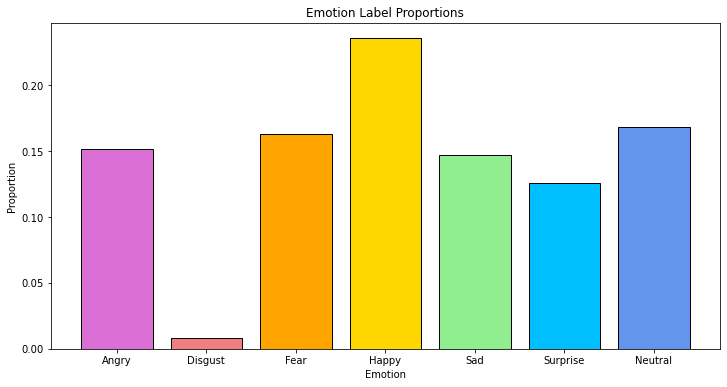

In [8]:
emotion_prop = (all_data.emotion.value_counts() / len(all_data)).to_frame().sort_index(ascending=True)

emotions = ['Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral']
palette = ['orchid', 'lightcoral', 'orange', 'gold', 'lightgreen', 'deepskyblue', 'cornflowerblue']

plt.figure(figsize=[12,6])

plt.bar(x=emotions, height=emotion_prop['emotion'], color=palette, edgecolor='black')
    
plt.xlabel('Emotion')
plt.ylabel('Proportion')
plt.title('Emotion Label Proportions')
plt.show()

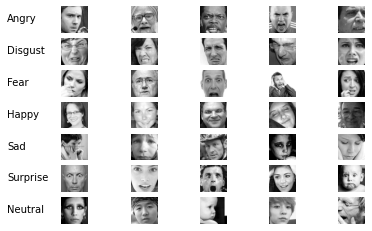

In [9]:
row = 0
for emotion in list(range(7)):

    all_emotion_images = all_data[all_data['emotion'] == emotion]
    for i in range(5):
        
        img = all_emotion_images.iloc[i,].pixels_arr.reshape(48,48)
        lab = emotions[emotion]
        
        plt.subplot(7,5,row+i+1)
        plt.imshow(img, cmap='binary_r')
        plt.axis('off')
    plt.text(-600, 27, s = str(lab), fontsize=10)
    row += 5

plt.show()

In [10]:
X_train, X_test, y_train, y_test = train_test_split(all_data['pixels_arr'], all_data['emotion'], test_size=0.2, random_state=12345)
print("Pixels as Single array")
print("Training data shape: ", X_train.shape)
print("Test data shape", X_test.shape)

Pixels as Single array
Training data shape:  (560,)
Test data shape (140,)


In [11]:
x_unraveled = pd.DataFrame(list(map(np.ravel, all_data['pixels_arr'])))
X_train_unrav, X_test_unrav, y_train_unrav, y_test_unrav = train_test_split(x_unraveled, y, test_size=0.2, random_state=12345)
print("Pixels as columns")
print("Training data shape: ", X_train_unrav.shape)
print("Test data shape", X_test_unrav.shape)


Pixels as columns
Training data shape:  (560, 2304)
Test data shape (140, 2304)


In [12]:
X_train_im, X_test_im, y_train_im, y_test_im = train_test_split(X, y, test_size=0.2, random_state=12345)
print("Converted Images")
print("Training data shape: ", X_train_im.shape)
print("Test data shape", X_test_im.shape)

Converted Images
Training data shape:  (560, 48, 48, 1)
Test data shape (140, 48, 48, 1)


## K Nearest Neighbors Model

In [13]:
knn = KNeighborsClassifier(algorithm='auto')
param_grid = dict(n_neighbors=list(range(1, 31)))
model_KNN = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy',verbose=1)

model_KNN.fit(X_train_unrav, y_train)
y_pred_KNN = model_KNN.predict(X_test_unrav)


Fitting 10 folds for each of 30 candidates, totalling 300 fits


/Users/reecekoe/opt/anaconda3/envs/global/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   50.9s finished


In [17]:
accuracy_dict['KNN'] = accuracy_score(y_pred_KNN, y_test)

print(f"The model is {accuracy_dict['KNN']*100:.2f}% accurate")

The model is 26.43% accurate


## SVM Model

In [ ]:
# param_grid = {'C':[1,10],'gamma':[0.001,0.1],'kernel':['rbf','poly']}
param_grid = {'C':[0.1,1,10,100],'gamma':[0.0001,0.001,0.1,1],'kernel':['rbf','poly', 'linear']}
svc = svm.SVC(probability=True)
print("The training of the model is started, please wait for while as it may take few minutes to complete")

model_SVM = GridSearchCV(svc,param_grid)

start = time.time()
model_SVM.fit(X_train_unrav,y_train)
end = time.time()

print(f"Train time {end-start}")

The training of the model is started, please wait for while as it may take few minutes to complete


/Users/reecekoe/opt/anaconda3/envs/global/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


In [ ]:
print('The Model is trained well with the given images')
model_SVM.best_params_

In [ ]:
y_pred_SVM = model_SVM.predict(X_test_unrav)
accuracy_dict['SVM'] = accuracy_score(y_pred_SVM, y_test)

print(f"The model is {accuracy_dict['SVM']*100:.2f}% accurate")

## Bernoulli Naive Bayes Model

In [ ]:
alphas = {'alpha': [1.0e-10, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}

bnb = BernoulliNB(binarize=0.1)
model_BNB = GridSearchCV(bnb, alphas, scoring='accuracy')
model_BNB.fit(X_train_unrav, y_train) 

y_pred_BNB = model_BNB.predict(X_test_unrav) 
accuracy_dict['BNB'] = accuracy_score(y_pred_BNB,y_test)

print(f"The model is {accuracy_dict['BNB']*100:.2f}% accurate")
# for test_al, test_score in zip(alphas['alpha'], model_BNB.cv_results_['mean_test_score']):
#     print(f"alpha value {test_al:6} had an accuracy of {test_score*100:.1f}%")            

## Multinomial Naive Bayes Model

In [ ]:
model_MNB = MultinomialNB()
model_MNB.fit(X_train_unrav, y_train)
y_pred_MNB = model_MNB.predict(X_test_unrav)
accuracy_dict['MNB'] = accuracy_score(y_pred_MNB,y_test)

print(f"The Naive Bayes model is {accuracy_dict['MNB']*100:.2f}% accurate")

## Gaussian Naive Naive Bayes Model

In [ ]:
model_GNB2 = GaussianNB(var_smoothing=.1)
model_GNB2.fit(X_train_unrav, y_train)
y_pred_GNB2 = model_GNB2.predict(X_test_unrav)
accuracy_dict['GNB'] = accuracy_score(y_pred_GNB2,y_test)
print(f"Gaussian Naive Bayes model with var_smoothing set to 0.1 had accuracy {accuracy_dict['GNB']*100:.2f}%")

## CNN Model 